# Analyzing Training, Validation, and Testing Sets

Investigation of the dataset for new reflector short tank data

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from exploratory_data_analysis_utils import *

# Load Data From H5

In [4]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/tts_egamma/IWCD_mPMT_Short_eg_1p5ns.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


# Load Indices

In [5]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/tts_egamma/IWCD_mPMT_Short_eg_1p5ns_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

# compute and save event radii

In [6]:
# compute and save event radii

radii = np.sqrt(positions[:,0,0]**2 + positions[:,0,2]**2)

np.savez('event_radii.npz', radii=radii)


In [7]:
radii_data = np.load('event_radii.npz', allow_pickle=True)

radii = radii_data['radii']

# Get indices associated with each dataset and particle type

In [8]:
train_g_idxs = train_idxs[np.where(labels[train_idxs]==0)[0]]
val_g_idxs   = val_idxs[np.where(labels[val_idxs]==0)[0]]
test_g_idxs  = test_idxs[np.where(labels[test_idxs]==0)[0]]
train_e_idxs = train_idxs[np.where(labels[train_idxs]==1)[0]]
val_e_idxs   = val_idxs[np.where(labels[val_idxs]==1)[0]]
test_e_idxs  = test_idxs[np.where(labels[test_idxs]==1)[0]]

# Initialize Detector Geometry Parameters

In [9]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

# Distribution of total charge

In [10]:
pbar = ProgressBar(widgets=['Calculating Event Total Charge. Progress: ', Percentage(),
                            ' ', Bar(marker='0',left='[',right=']'), ' ', ETA()],
                   maxval=positions.shape[0])

pbar.start()
total_charge = []
for i in range(positions.shape[0]):
    pbar.update(i)
    start = event_hits_index[i]
    stop  = event_hits_index[i + 1]
    charge = hit_charge[start:stop]

    total_charge.append(np.sum(charge))
    
pbar.finish()

np.savez('total_charge.npz',   total_charge=total_charge)

Calculating Event Total Charge. Progress: 100% [0000000000000000] Time: 0:04:26


In [11]:
total_charge = np.load('total_charge.npz', allow_pickle=True)['total_charge']

In [12]:
hdf5_hit_pmt.shape[0]

23989462754

In [13]:
event_hits_index[-3:]

array([23989457867, 23989461166, 23989462754])

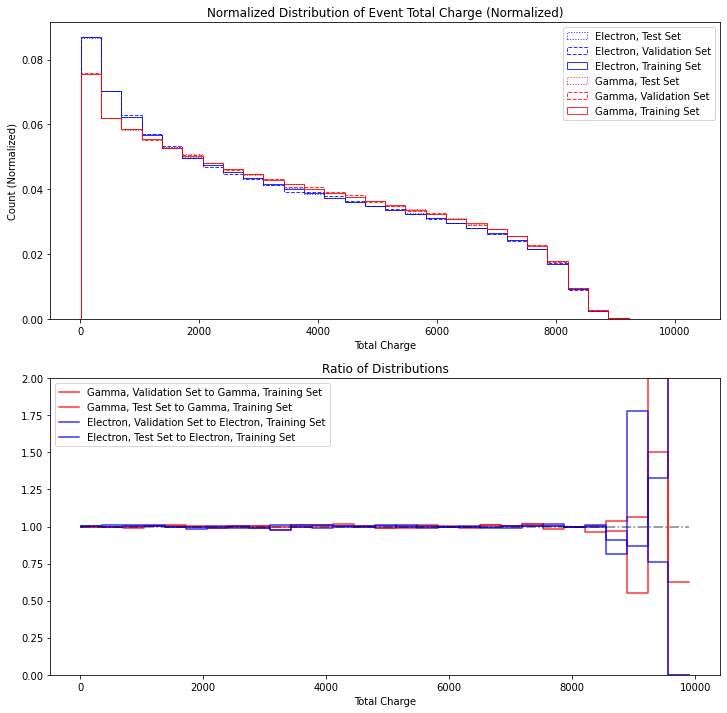

In [14]:
# plot total charge for different datasets
fig = plot_compare_dists([total_charge[train_g_idxs],
                          total_charge[val_g_idxs],
                          total_charge[test_g_idxs],
                          total_charge[train_e_idxs],
                          total_charge[val_e_idxs],
                          total_charge[test_e_idxs]],
                         bins=30,
                         numerator_dist_idxs   = [1,2,4,5],
                         denominator_dist_idxs = [0,0,3,3],
                         labels= ['Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set'],
                         ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',
                         colors=['r','r','r','b','b','b'],
                         linestyle=['-','--',':','-','--',':'],
                         xlabel='Total Charge'
                        )

/home/nprouse/WatChMaL/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


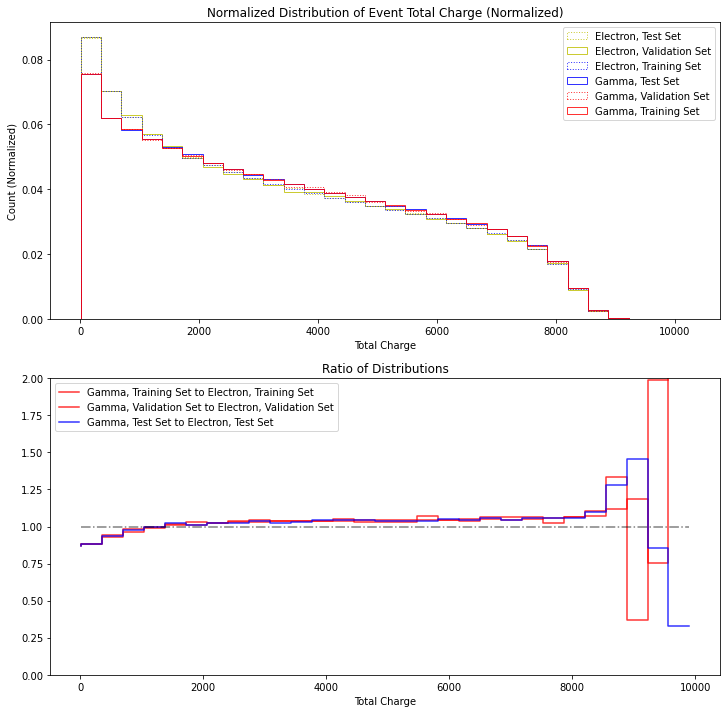

In [37]:
# plot total charge for different datasets
fig = plot_compare_dists([total_charge[train_g_idxs],
                          total_charge[val_g_idxs],
                          total_charge[test_g_idxs],
                          total_charge[train_e_idxs],
                          total_charge[val_e_idxs],
                          total_charge[test_e_idxs]],
                         bins=30,
                         numerator_dist_idxs   = [0,1,2],
                         denominator_dist_idxs = [3,4,5],
                         labels= ['Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set'],
                         ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',
                         colors=['r','r','b','b','y','y'],
                         linestyle=['-',':','-',':','-',':'],
                         xlabel='Total Charge'
                        )

# Max Charge

In [16]:
pbar = ProgressBar(widgets=['Calculating Event Max Charge. Progress: ', Percentage(),
                            ' ', Bar(marker='0',left='[',right=']'), ' ', ETA()],
                   maxval=positions.shape[0])

pbar.start()
max_charge = []
for i in range(positions.shape[0]):
    pbar.update(i)
    
    start = event_hits_index[i]
    stop  = event_hits_index[i + 1]
    charge = hit_charge[start:stop]

    max_charge.append(np.max(charge))
        
pbar.finish()

np.savez('max_charge.npz', max_charge=max_charge)

Calculating Event Max Charge. Progress: 100% [000000000000000000] Time: 0:03:29


In [34]:
max_charge = np.load('max_charge.npz', allow_pickle=True)['max_charge']

Bins:  [1.2031065e+00 1.0764467e+02 2.1408623e+02 3.2052780e+02 4.2696936e+02
 5.3341089e+02 6.3985248e+02 7.4629407e+02 8.5273560e+02 9.5917719e+02
 1.0656188e+03 1.1720603e+03 1.2785018e+03 1.3849434e+03 1.4913850e+03
 1.5978265e+03 1.7042681e+03 1.8107096e+03 1.9171512e+03 2.0235928e+03
 2.1300344e+03 2.2364758e+03 2.3429175e+03 2.4493591e+03 2.5558005e+03
 2.6622422e+03 2.7686836e+03 2.8751252e+03 2.9815669e+03 3.0880083e+03
 3.1944500e+03]


/home/nprouse/WatChMaL/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/home/nprouse/WatChMaL/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/home/nprouse/WatChMaL/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/home/nprouse/WatChMaL/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
/home/nprouse/WatChMaL/WatChMaL_analysis/tts_EDA/exploratory_data_analysis_utils.py:164: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


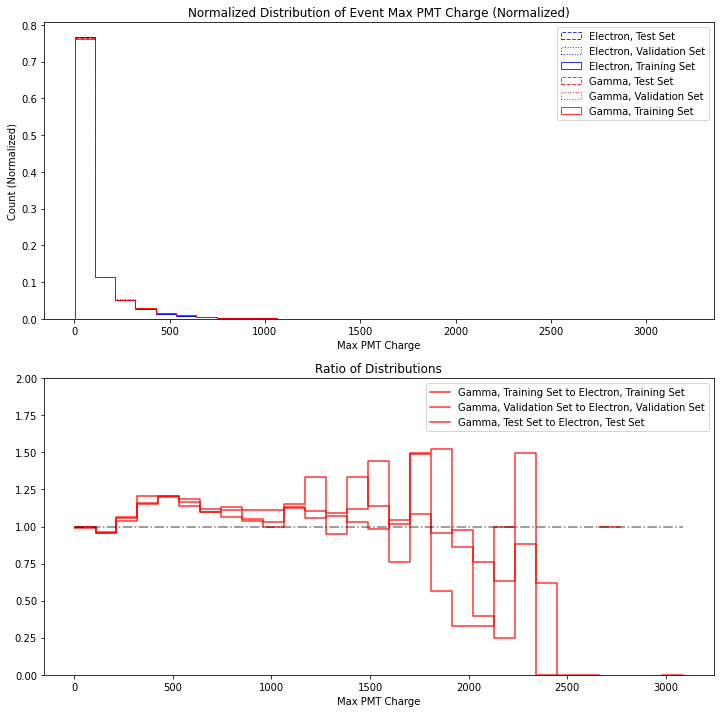

In [36]:
fig = plot_compare_dists([
                    max_charge[train_g_idxs], max_charge[val_g_idxs], max_charge[test_g_idxs],
                    max_charge[train_e_idxs], max_charge[val_e_idxs], max_charge[test_e_idxs]],
                    bins=30,
                    numerator_dist_idxs   = [0,1,2],
                    denominator_dist_idxs = [3,4,5],
                    labels= ['Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                             'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set'],
                    ratio_range=[0,2],
                    title='Normalized Distribution of Event Max PMT Charge',
                    colors=['r','r','r','b','b','b'],
                    linestyle=['-',':','--','-',':','--'],
                    xlabel='Max PMT Charge',
                    verbose=True
                    )
